<a href="https://colab.research.google.com/github/trulicup/COVID-19-SARS-B-cell-Epitope-Prediction/blob/main/SARS_B_cell_Epitope_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**What is an epitope?**

Simply put, an **epitope** is the antibody binding site on an antigen.

When a foreign molecule is detected for the first time by the immune system of an organism the molecule, which is normally a protein, is captured by an army of highly specialized cells. One example is **dendritic cells**, which are antigen presenting cells responsible for helping to break down the foreign molecule into smaller parts and presenting them to **B cell lymphocytes** in the form of **antigens**.

Following Antigen Presentation, a cellular mechanism called Somatic Hypermutation initiates the coding process by the B cell lymphocyte of a new antibody. The Antigen Binding Site of the variable region of the antibody will be unique in order to specifically bind to an epitope derived from the antigen.

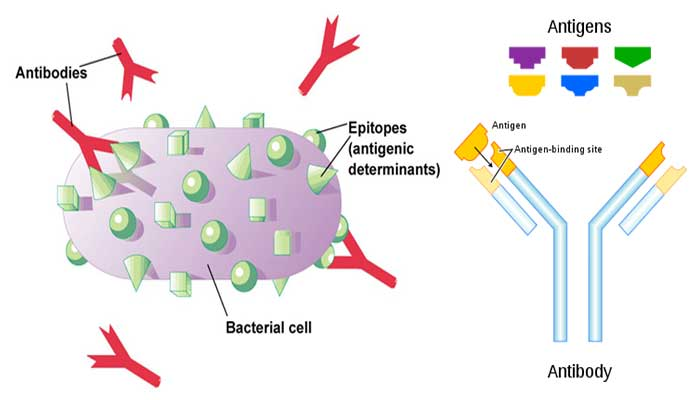

Check out this website to get a better undestanding of how this works: 
https://www.prosci-inc.com/resources/antibody-development-guide/what-is-an-epitope/

**Task:**

Our goal today is to build a Deep Neural Network (DNN) model using tensorflow to predict epitope regions on a SARS protein.

**If you are running this notebook on colab, make sure you change runtime type to GPU**

# Download Datasets

To get started, lets upload our kaggle account API key to download the COVID-19/SARS B-cell Epitope dataset.

In [ ]:
from google.colab import files
files.upload() # Upload kaggle.json

from google.colab import output
output.clear()

In [ ]:
# Make directory and move api key
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Fetch datasets
!kaggle datasets download -d futurecorporation/epitope-prediction
!unzip -q epitope-prediction.zip -d .

output.clear()

!ls

epitope-prediction.zip	input_covid.csv  kaggle.json
input_bcell.csv		input_sars.csv	 sample_data


# Reproducibility

Reproducibility is key for peer review, so we will set our global random number generators to a fixed value using a global seed.

In [ ]:
GLOBAL_SEED = 20

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

# A functionn that resets the random seeds back to our default global seed
def reset_random_seeds(seed_value):
   os.environ['PYTHONHASHSEED']=str(seed_value)
   random.seed(seed_value)
   np.random.seed(seed_value)
   tf.random.set_seed(seed_value)

In [ ]:
reset_random_seeds(GLOBAL_SEED)

# Exploratory Analysis and Data Pre-processing

Before we begin building our model, we will explore and analize our datasets to look for key insights that could help us build a more robust and efficient model.

### Raw Data Analysis

Lets load our datasets into a pandas dataframes and see what insights we can observe right from the start.

In [ ]:
import pandas as pd

bcell_df = pd.read_csv(f'input_bcell.csv')
sars_df = pd.read_csv(f'input_sars.csv')

In [ ]:
bcell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14387 entries, 0 to 14386
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    14387 non-null  object 
 1   protein_seq          14387 non-null  object 
 2   start_position       14387 non-null  int64  
 3   end_position         14387 non-null  int64  
 4   peptide_seq          14387 non-null  object 
 5   chou_fasman          14387 non-null  float64
 6   emini                14387 non-null  float64
 7   kolaskar_tongaonkar  14387 non-null  float64
 8   parker               14387 non-null  float64
 9   isoelectric_point    14387 non-null  float64
 10  aromaticity          14387 non-null  float64
 11  hydrophobicity       14387 non-null  float64
 12  stability            14387 non-null  float64
 13  target               14387 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 1.5+ MB


In [ ]:
sars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    520 non-null    object 
 1   protein_seq          520 non-null    object 
 2   start_position       520 non-null    int64  
 3   end_position         520 non-null    int64  
 4   peptide_seq          520 non-null    object 
 5   chou_fasman          520 non-null    float64
 6   emini                520 non-null    float64
 7   kolaskar_tongaonkar  520 non-null    float64
 8   parker               520 non-null    float64
 9   isoelectric_point    520 non-null    float64
 10  aromaticity          520 non-null    float64
 11  hydrophobicity       520 non-null    float64
 12  stability            520 non-null    float64
 13  target               520 non-null    int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 57.0+ KB


**Insights:**

*   `parent_protein_id`, `protein_seq`, and `peptide_seq` are of data type `object` which means they are our categorical variables.
*   `target` (our label for these datasets) is of data type `int64`.
*   All the other variables excluding the ones metioned above, can be treated as continuous variables.
*   Also there are no missing datapoints.



In [ ]:
bcell_df.describe(include=['int64', 'float64'])

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
count,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000,14387.000000
mean,297.675818,308.085077,0.994706,1.059788,1.021188,1.767137,7.067472,0.075727,-0.406097,43.703902,0.271217
std,353.741450,353.733297,0.124772,1.621931,0.053804,1.968985,1.888708,0.025767,0.394618,16.682362,0.444603
min,1.000000,6.000000,0.534000,0.000000,0.838000,-9.029000,3.686096,0.000000,-1.971171,5.448936,0.000000
25%,84.000000,95.000000,0.911000,0.248000,0.986000,0.600000,5.621033,0.060606,-0.606215,31.614529,0.000000
50%,191.000000,200.000000,0.990000,0.556000,1.020000,1.793000,6.499573,0.074534,-0.330540,42.287268,0.000000
75%,382.000000,393.000000,1.074000,1.209000,1.055000,3.009500,8.676575,0.091312,-0.189591,49.101172,1.000000
max,3079.000000,3086.000000,1.546000,27.189000,1.255000,9.120000,12.232727,0.182254,1.267089,137.046667,1.000000


In [ ]:
sars_df.describe(include=['int64', 'float64'])

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,5.200000e+02,5.200000e+02,5.200000e+02,520.000000
mean,617.871154,635.876923,1.000442,1.719804,1.038960,1.278696,5.569763,1.163347e-01,-6.111554e-02,3.320512e+01,0.269231
std,349.582246,349.315328,0.087190,4.736354,0.037978,1.418791,0.000000,1.444680e-15,6.389930e-16,7.823496e-14,0.443987
min,1.000000,10.000000,0.621000,0.000000,0.908000,-7.467000,5.569763,1.163347e-01,-6.111554e-02,3.320512e+01,0.000000
25%,359.000000,373.750000,0.949000,0.179750,1.013000,0.534500,5.569763,1.163347e-01,-6.111554e-02,3.320512e+01,0.000000
50%,571.500000,592.500000,1.009000,0.439500,1.036000,1.412000,5.569763,1.163347e-01,-6.111554e-02,3.320512e+01,0.000000
75%,921.000000,940.000000,1.055250,1.181250,1.058000,2.245000,5.569763,1.163347e-01,-6.111554e-02,3.320512e+01,1.000000
max,1241.000000,1255.000000,1.317000,40.605000,1.228000,4.907000,5.569763,1.163347e-01,-6.111554e-02,3.320512e+01,1.000000


**Insights:**

*   The range for the continuous values are all over the place so we will have to add a normalization layer to the model to make sure the model has an easier time digesting this dataset.
*   `target` seems to be binary so the model will be a binary classifier.

In [ ]:
bcell_df.describe(include=['object'])

,parent_protein_id,protein_seq,peptide_seq
count,14387,14387,14387
unique,760,757,14362
top,P10155,MEESVNQMQPLNEKQIANSQDGYVWQVTDMNRLHRFLCFGSEGGTY...,ARDVLAVVSK
freq,560,560,3


In [ ]:
bcell_df.describe(include=['object'])

,parent_protein_id,protein_seq,peptide_seq
count,14387,14387,14387
unique,760,757,14362
top,P10155,MEESVNQMQPLNEKQIANSQDGYVWQVTDMNRLHRFLCFGSEGGTY...,ARDVLAVVSK
freq,560,560,3


**Insights:**

*   `parent_protein_id` and `protein_seq` are practically identical so for simplicity's sake, we will ignore their differences.



### Data Preprocessing

To improve the quality of the input data, we will modify some raw variables.

In [ ]:
# Map modified variables to new columns
bcell_df['protein_seq_length'] = bcell_df.apply(lambda row: len(row.protein_seq), axis=1)
bcell_df['peptide_length'] = bcell_df.apply(lambda row: len(row.peptide_seq), axis=1)
bcell_df['peptide_region'] = bcell_df.apply(lambda row: row.start_position / row.protein_seq_length, axis=1)

sars_df['protein_seq_length'] = sars_df.apply(lambda row: len(row.protein_seq), axis=1)
sars_df['peptide_length'] = sars_df.apply(lambda row: len(row.peptide_seq), axis=1)
sars_df['peptide_region'] = sars_df.apply(lambda row: row.start_position / row.protein_seq_length, axis=1)

In [ ]:
# Drop the old raw variables
bcell_df.drop(columns=['parent_protein_id', 'protein_seq', 'peptide_seq', 'start_position', 'end_position'], inplace=True)
sars_df.drop(columns=['parent_protein_id', 'protein_seq', 'peptide_seq', 'start_position', 'end_position'], inplace=True)

### Extra-trees Feature Importance

A great way to assess the quality of the input data is to use a simple model, something like an Extra-trees Classifier, to get a rough estimate of how important some features are for making simple predictions.

In [ ]:
# Seperate features and labels for the extra-trees classifier 
trees_features = bcell_df.drop(columns=['target'])
trees_labels = bcell_df['target']

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Load and run the simple model
classifier = ExtraTreesClassifier(random_state=0)
classifier.fit(trees_features, trees_labels)

# Extract and normalize feature importance
feature_importance = classifier.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis = 0)

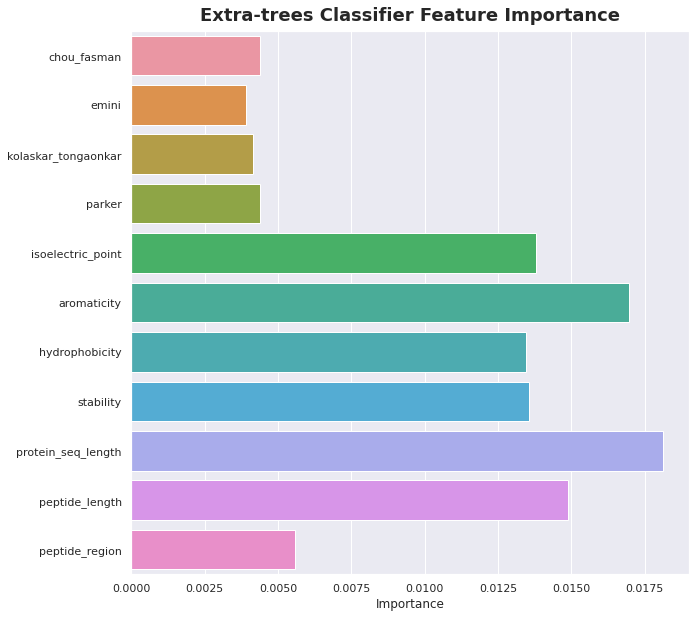

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid', palette=sns.color_palette('Set2'), color_codes=True)

# Plot feature importance
plt.figure(figsize=(10,10))
sns.barplot(x=feature_importance_normalized, y=trees_features.columns) 
plt.xlabel('Importance') 
plt.title('Extra-trees Classifier Feature Importance', weight='bold', fontdict={'fontsize': 18}, pad=10)
plt.show() 

**Insights:**

*   Clearly some features are favored more than others, but all features are important enough to keep.



### Data Distribution

Now we will analize the distribution of our `bcell_df` dataset.

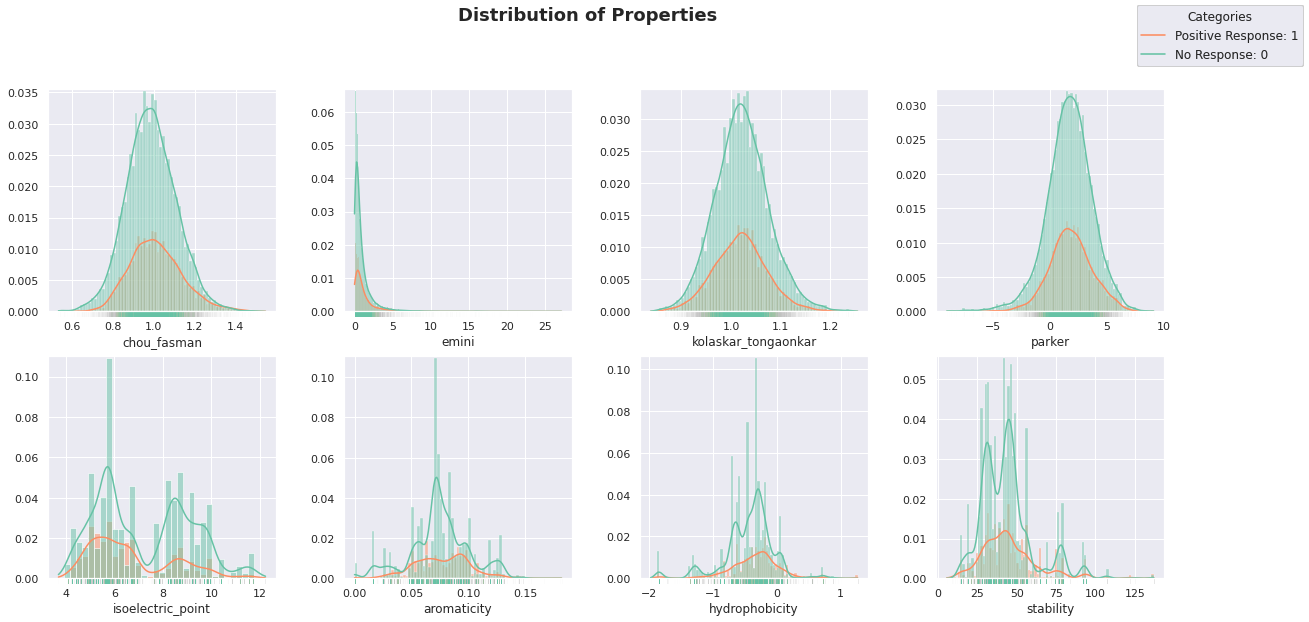

In [ ]:
# Label and columns of interest
label_name = 'target'
feature_columns = ['chou_fasman', 'emini', 'kolaskar_tongaonkar', 'parker', 
                    'isoelectric_point', 'aromaticity', 'hydrophobicity', 'stability']

# General formatting for plots
fig, axes = plt.subplots(2, 4,figsize=(20,9))
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Distribution of Properties', fontsize=18, weight='bold', va='bottom')
axes = axes.ravel()

# Create a set of histogram plots
for i,name in enumerate(feature_columns): 
  value = bcell_df[[name, label_name]]
  
  g = sns.histplot(data=value, x=name, hue=label_name, kde=True, stat='probability', legend=False, ax=axes[i])
  g = sns.rugplot(data=value, x=name, height=-.02, clip_on=False, lw=1, alpha=.005, ax=axes[i])

  g.set(ylabel=None)
  fig.legend(labels = ['Positive Response: 1','No Response: 0'], loc="upper right", 
             fontsize=12, fancybox=True, title='Categories', borderpad=0.4)

**Insights:**

*   First thing to notice is that `emini` has some very sparse outliers on the right.
*   For hydrophobicity, `target` values of 1 are slightly less negative than `target` values of 0.



### Protein Sequences Visualization

To get a better undestanding of how the location of the epitope affects its properties, we will plot them on their respective protein sequences and visualize their properties.

In [ ]:
from scipy import stats

# Clone the bcell dataset so no modifications are made to the original dataset
scatter_plot_df = bcell_df.copy(deep=True)

# Noemalize the distribution of protein length for better visualization
scatter_plot_df['protein_seq_length'] = stats.boxcox(scatter_plot_df['protein_seq_length'])[0]

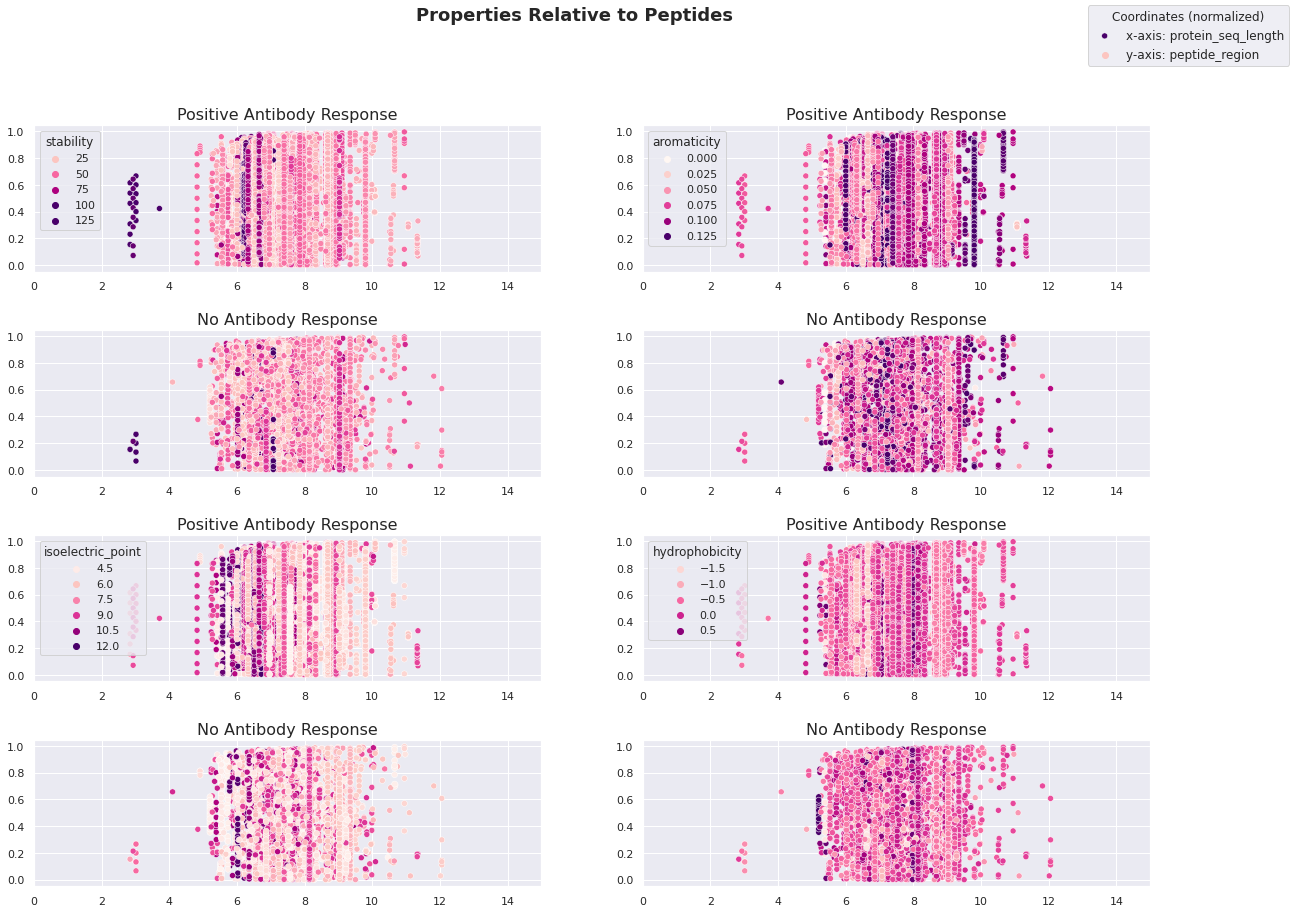

In [ ]:
# Split cloned dataset based on the 'target' values
positive_response_df = scatter_plot_df[scatter_plot_df.target == 0]
no_response_df = scatter_plot_df[scatter_plot_df.target == 1]

# Properties of interest and their corresponding ranges
properties_of_interest = ['stability', 'aromaticity', 'stability', 'aromaticity', 
                      'isoelectric_point', 'hydrophobicity', 'isoelectric_point', 'hydrophobicity']
hue_norms = [(0, 100), (0, 0.125), (0, 100), (0, 0.125), (4, 12), (-2, 1), (4, 12), (-2, 1)]

# General formating for plots
fig, axs = plt.subplots(4, 2,figsize=(20,14))
fig.subplots_adjust(hspace = 0.4)
fig.suptitle('Properties Relative to Peptides', fontsize=18, weight='bold', va='bottom')
axs = axs.ravel()

# Create two scatter plots for each property (one for each target value)
for i,name in enumerate(properties_of_interest):

  if i == 0 or i == 1 or i == 4 or i == 5:
    axs[i].set_title(label='Positive Antibody Response', fontdict={'fontsize': 16})
    g = sns.scatterplot(data=positive_response_df, x='protein_seq_length', y='peptide_region', 
                            hue=name, hue_norm=hue_norms[i], palette='RdPu', ax=axs[i])
    g.legend(loc='upper left')

  elif i == 2 or i == 3 or i == 6 or i == 7:
    axs[i].set_title(label='No Antibody Response', fontdict={'fontsize': 16})
    g = sns.scatterplot(data=no_response_df, x='protein_seq_length', y='peptide_region', 
                            hue=name, hue_norm=hue_norms[i], palette='RdPu', legend=False, ax=axs[i])
  
  g.set(xlabel=None, ylabel=None, xlim=(0, 15))


fig.legend(labels = ['x-axis: protein_seq_length', 'y-axis: peptide_region'], loc="upper right", 
                      fontsize=12, fancybox=True, title='Coordinates (normalized)', borderpad=0.4)

**Insights:**

*   Clearly there are property differences between active and non-active epitopes, but they look too complex for a person or a simple model to extract.



### Features Correlation Matrix

Finally, to end our Exploratory Data Analysis (EDA), we will take a look a the correlations between our features.

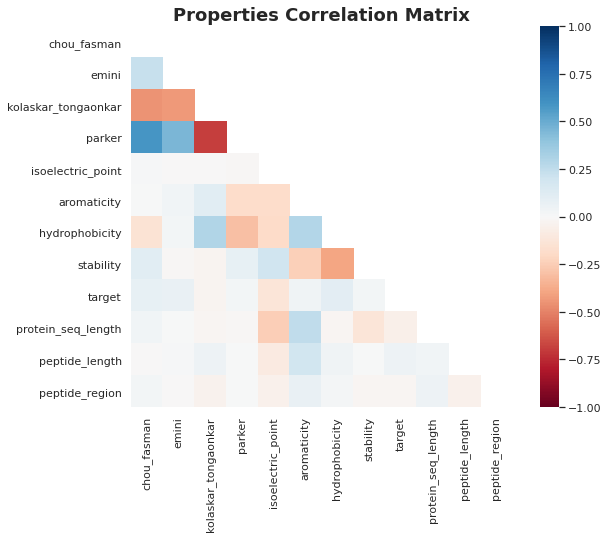

In [ ]:
# Generate correlation matrix
corr_matrix = bcell_df[bcell_df.columns].corr()

# Create mask to remove duplicates
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Plot correlation matrix
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(10, 7))
  plt.title('Properties Correlation Matrix', fontsize=18, weight='bold')
  ax = sns.heatmap(corr_matrix, mask=mask, square=True, cmap='RdBu', vmin=-1, vmax=1)

**Insights:**

*   There are enough possitive and negative correlations between our features that we could create new fetures based on those correlation, but I don't personally know enough about micro-biology. 
*   If you have a better understanding of this field, then you could make some improvements here.



# Model

### Class Imbalance

Class imbalance is when labels are not evenly represented in the training dataset. this can lead to unreliable performance metrics if the more saught after labels (positive predictions in this case) is underrepresented.

Lets take a look at our labels distribution.

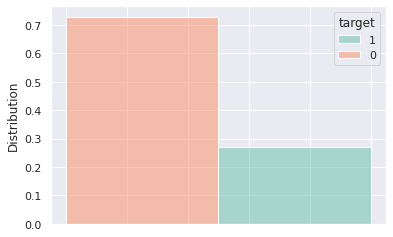

In [ ]:
with sns.axes_style('darkgrid'):
  g = sns.histplot(data=bcell_df, x='target', hue='target', 
                   hue_order=[1,0], bins=2, stat='probability')
  g.set(xticklabels=[], xlabel=None, ylabel='Distribution')

**Insight:**
  * ~73% of the label values in this dataset are 0 (no antibody response) and ~27% are 1 (positive antibody response). This means that there is a class imbalance that we need to take into account.

We can create a function that represents this class imbalance as a ratio and pass that to our model as the `class weights`.

In [ ]:
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

CLASS_WEIGHTS = get_class_weights(bcell_df.target.values)
print(CLASS_WEIGHTS)

{1: 2.69, 0: 1.0}


### Data Split

Lets shuffle and split our data for training the model.

In [ ]:
from sklearn.model_selection import train_test_split

features_bcell_df = bcell_df.drop(columns=['target'])
targets_bcell_df = bcell_df['target'].astype({'target': 'category'})

train_features, test_features, train_labels, test_labels = train_test_split(features_bcell_df, targets_bcell_df, 
                                                                            test_size=0.20, shuffle=True,
                                                                            random_state=GLOBAL_SEED)

Why don't we use the sars dataset as the testing dataset?
> Yes it would be much easier to use the sars dataset as the testing dataset and build a better model by improving the test dataset prediction accurary, but this would not be a very helpful aproach for our end goal, which is to make predictions on an unlabeled covid dataset.
>
> Thus, the sars dataset needs to be treated as an unlabeled dataset. This will allow us to build a model that performs better on the unlabled covid dataset.

Why do we use an 80/20 split?
> We're using a larger testing dataset split because the `b_cell` datasset is not very large.

### Tensorflow Model

Now for the fun part. Lets build and train our model!
We will be making a tensorlfow `keras` model and use a very fun tensorflow library called `tensorflow_addons` to improve our model's performance.

In [ ]:
import tensorflow_addons as tfa

# Import PlotLossesKeras from livelossplot for live training visualization
!pip install livelossplot
from livelossplot import PlotLossesKeras

output.clear()

Lets create a function that builds and returns our model.

In [ ]:
def model_builder(dropout, opt, loss):
  reset_random_seeds(20)

  # Normalization layers
  inputs = tf.keras.Input(shape=(train_features.shape[-1],))
  x = tf.keras.layers.experimental.preprocessing.Normalization()(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # Feature extraction layers
  x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(units = 2000))(x)
  x = tf.keras.layers.PReLU()(x)
  x = tf.keras.layers.AlphaDropout(dropout*1.5)(x)

  x = tf.keras.layers.Dense(units = 1024)(x)
  x = tf.keras.layers.PReLU()(x)
  x = tf.keras.layers.AlphaDropout(dropout)(x)

  # Compression layers
  x = tf.keras.layers.Dense(units = 512)(x)
  x = tf.keras.layers.PReLU()(x)
  x = tf.keras.layers.Dense(units = 256)(x)
  x = tf.keras.layers.PReLU()(x)
  x = tf.keras.layers.Dense(units = 64)(x)
  x = tf.keras.layers.PReLU()(x)
  x = tf.keras.layers.Dense(units = 16)(x)
  x = tf.keras.layers.PReLU()(x)

  # Output layer
  outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)

  # Ensemble model
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name="SARS_Epitone_Region_Binary_Classifier")
  
  model.compile(optimizer = opt, loss = loss, metrics = [tf.keras.metrics.AUC()])

  return model

Now, lets declare our hyperparameters.

In [ ]:
# Hyperparameters

# Batch size
BATCH_SIZE = 512

# Epochs
EPOCHS = 50

# Optimizersars_df
STEPS_PER_EPOCH = len(train_features.index)//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.0003,
  decay_steps=STEPS_PER_EPOCH*10,
  decay_rate=0.0,
  staircase=True)

OPT = tfa.optimizers.LazyAdam(lr_schedule)

# Loss Function
# LOSS = tf.keras.losses.MeanSquaredLogarithmicError()
LOSS = tf.keras.losses.Huber(delta=2)

# Dropout - explain
DROPOUT = 0.3

# early_stopping callback function
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                                  mode='auto', restore_best_weights=False)

And Finally, lets create and train our model.

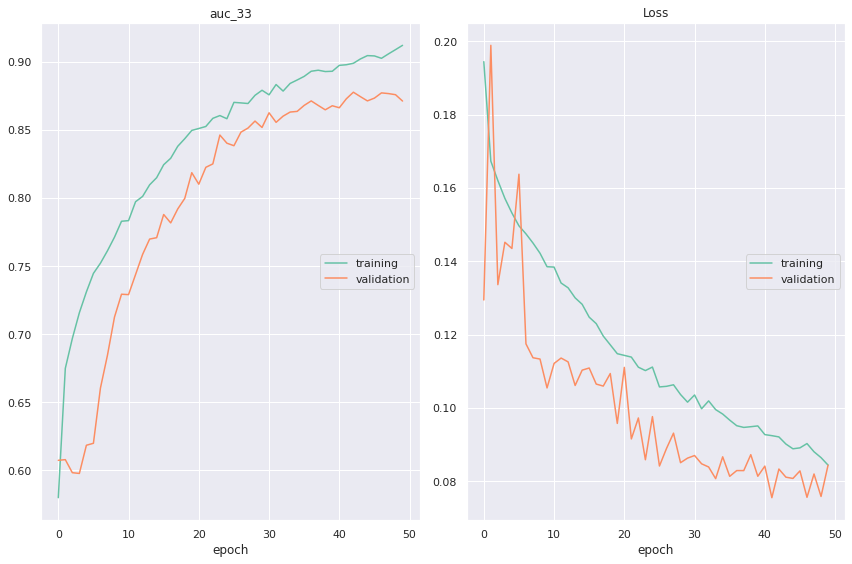

auc_33
	training         	 (min:    0.580, max:    0.912, cur:    0.912)
	validation       	 (min:    0.598, max:    0.878, cur:    0.871)
Loss
	training         	 (min:    0.084, max:    0.194, cur:    0.084)
	validation       	 (min:    0.076, max:    0.199, cur:    0.084)


In [ ]:
model = model_builder(DROPOUT, OPT, LOSS)

history = model.fit(train_features, train_labels,
                    class_weight=CLASS_WEIGHTS, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=0, 
                    callbacks=[PlotLossesKeras(), early_stopping],
                    validation_data=(test_features, test_labels)
                    )

**Disclaimer:**
*   Model performance might vary slightly from run to run.


In [ ]:
model.summary()

Model: "SARS_Epitone_Region_Binary_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 11)]              0         
_________________________________________________________________
normalization_33 (Normalizat (None, 11)                23        
_________________________________________________________________
batch_normalization_33 (Batc (None, 11)                44        
_________________________________________________________________
weight_normalization_33 (Wei (None, 2000)              50001     
_________________________________________________________________
p_re_lu_198 (PReLU)          (None, 2000)              2000      
_________________________________________________________________
alpha_dropout_66 (AlphaDropo (None, 2000)              0         
_________________________________________________________________
dense_232 (Dense)            


*   The model has 2.75M trained parameters. This allows for plenty of room for a wider dataset.


# Predictions

In [ ]:
features_sars_df = sars_df.drop(columns=['target'])
targets_sars_df = sars_df['target'].astype({'target': 'category'})

In [ ]:
preds = model.evaluate(features_sars_df, targets_sars_df, 
                        steps=len(features_sars_df.index), verbose=1)

520/520 [==============================] - 2s 3ms/step - loss: 0.2303 - auc_33: 0.5475


**Insight:**
*   The validation dataset AUC (0.547) is radically different from the testing datset AUC (0.871). This suggest that there could be little correlation between the two datasets. This usually means that the testing set is not representitive of the validation dataset.



# Room for Improvement

There are a series of steps that can be taken to improve validation dataset accuracy:
*   Provide protein cluster and/or domain groups to implement Neural Structured Learning. https://www.tensorflow.org/neural_structured_learning
*   Limit training samples to only include proteins from the same or neighbouring clusters.
*   Replace model architecture with one based on Tensorflow Probability, to better learn nonlinear relationships. https://www.tensorflow.org/probability
*   Further optimize hyperparameters and model architecture.
